# The search.py module

Introduction
============

Hello!
In this IPython notebook, we'll study different kinds of search techniques used in [ search.py ]( https://github.com/aimacode/aima-python/blob/master/search.py ) and try to get an intuition of what search algorithms are best suited for various problems. We first explore uninformed search algorithms and later get our hands on heuristic search strategies.

The code in this IPython notebook, and the entire `aima-python` repository is intended to work with Python 3 (specifically, Python 3.4). So if you happen to be working on Python 2, you should switch to Python 3. For more help on how to install python3, or if you are having other problems, you can always have a look the `intro` IPython notebook. 

Now that you have all that sorted out, let's get started!

## Uninformed Search Strategies

Uninformed Search strategies are called `blind search`. In such search strategies, the only information we have about any state is generated by checking if a piece of data, or any of its successors, matches our `goal state` or not. THAT'S IT. NOTHING MORE. (Well ....not really. See the `value` method defined in the following section).

First let's formulate the problem we intend to solve. So let's import everything from our module.

In [1]:
from search import *

The search and other modules of the repository make use of several imports from the utils module. We will point the useful ones out if they are required to follow the material below. Don't worry. You don't need to read utils.py in order to understand search algorithms.
    
The `Problem` class is an abstract class on which we define our problems(*duh*).
Again, if you are confused about what `abstract class` means have a look at the `Intro` notebook.
The `Problem` class has six methods.
* `__init__(self, initial, goal)` : This is what is called a `constructor` and is the first method called when you create an instance of class. In this and all of the below methods `self` refers to the object itself--the object whose method is called. `initial` specifies the initial state of our search problem. It represents the start state from where our agent begins his task of exploration to find the goal state(s) which is given in the `goal` parameter.
* `actions(self, state)` : This method returns all the possible actions our agent can make in state `state`.
* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.
* `goal_test(self, state)` : Given a graph state, it checks if it is a terminal state. If the state is indeed a goal state, value of `True` is returned. Else, of course, `False` is returned.
* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.
* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimize a value when we cannot do a goal test.

Now the above abstract class acts as a parent class, and there is another named called `GraphProblem` in our module. It creates a graph problem from an instance of the `Graph` class. To create a graph, simply type `graph = Graph(dict(...))`. The dictionary must contain nodes of the graph as keys, so make sure they are `hashable`. If you don't know what that means just use strings or numbers. Each node contains the adjacent nodes as keys and the edge length as its value. Each dictionary then should correspond to another dictionary in the graph.  The `Graph` class creates a directed(edges allow only one way traffic) by default. If you want to make an undirected graph, use `UndirectedGraph` instead, but make sure to mention any edge in only one of its nodes.

If you didn't understand the above paragraph, `Fret not!`. Just think of the below code as a magicical method to create a simple undirected graph. I'll explain what it is about later.

In [2]:
museum_graph = UndirectedGraph(dict(
    Start = dict(Dog = 3, Cat = 9, Mouse = 4),
    Dog = dict(Bear = 7),
    Cat = dict(Monkey = 9, Fish = 8, Penguin = 3),
    Mouse = dict(Penguin = 2),
    Bear = dict(Monkey = 7),
    Monkey = dict(Giraffe = 11, Fish = 6),
    Fish = dict(Giraffe = 8),
    Penguin = dict(Parrot = 4, Elephant = 6),
    Giraffe = dict(Hen = 5),
    Parrot = dict(Hen = 10),
    Elephant = dict(Hen = 9)))

Imagine we are in a museum showcasing statues of various animals. To navigate through the museum there are paths between some statues and the entrance. We define the entrance and the statues as nodes in our graph with the path connecting them as edges. The cost/weight of an edge specifies is its length. So `Start = dict(Dog = 3, Cat = 9, Mouse = 4)` means that there are paths from `Start` to `Dog`, `Cat` and `Mouse` with path costs 3, 9 and 4 respectively. 

Here's an image below to better understand our graph.

<img src="images/search_animal.svg" width="80%">
<!-- Theses lovely animal icons were reproduced courtesy of Creative Tail https://www.creativetail.com/40-free-flat-animal-icons/ -->


### Breadth First Search

In Breadth First Search, the `shallowest` unexpanded node is chosen for expansion. That means that all nodes of a given depth must be expanded before any node of the next depth level. This search strategy accomplishes this by using a `FIFO` meaning 'First In First Out' queue. Anything that gets in the queue first also gets out first just like the checkout queue in a supermarket. To use the algorithm, first we need to define our problem. Say we want to find the statue of `Monkey` and we start from the entrance which is the `Start` state. We'll define our problem using the `GraphProblem` class.

In [3]:
monkey_problem = GraphProblem('Start', 'Monkey', museum_graph)

Now let's find the solution for our problem using the `breadth_first_search` method. Note that it returns a `Node` from which we can find the solution by looking at the path that was taken to reach there.

In [4]:
bfs_node = breadth_first_search(monkey_problem)
bfs_node.solution()

['Cat', 'Monkey']

We get the output as `['Cat', 'Monkey']`. That is because first the nodes `Dog`, `Cat` and `Mouse` are added to the `FIFO` queue in `some` order when we are expanding the `Start` node. Now when we start expanding nodes in the next level, only the `Cat` node gets us to `Monkey`. Note that during a breadth first search, the goal test is done when the node is being added to the queue.

### Uniform-cost Search

In Uniform-cost Search, we expand the node with the lowest path cost (the cost to reach that node from the start) instead of expanding the shallowest node. Rather than a `FIFO` queue, we use something called a `priority queue` which selects the element with the highest `priority` of all elements in the queue. For our problem, the shortest path between animals has the higher priority; the shortest path has the lowest path cost. Whenever we need to enqueue a node already in the queue, we will update its path cost if the newer path is better. This is a very important step, and it means that the path cost to a node may keep getting better until it is selected for expansion. This is the reason that we do a goal check only when a node is selected for expanion.

In [5]:
ucs_node = uniform_cost_search(monkey_problem)
ucs_node.solution()

['Dog', 'Bear', 'Monkey']

We got the path`['Dog', 'Bear', 'Monkey']` instead of `['Cat', 'Monkey']`. Why? The path cost is lower! We can also see the path cost with the path_cost attribute. Let's compare the path cost of the Breadth first search solution and Uniform cost search solution

In [6]:
bfs_node.path_cost, ucs_node.path_cost

(18, 17)

We were right! 

The path cost through the `Cat` statue is indeed more than the path cost through `Dog` even though the former passes through two roads compared to the three roads in the `ucs_node` solution.

# Romania map visualisations

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem to reach 'Bucharest' starting from 'Arad'. This is how the problem is defined:

In [7]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [8]:
romania_locations = romania_map.locations
print(romania_locations)

{'Giurgiu': (375, 270), 'Arad': (91, 492), 'Vaslui': (509, 444), 'Iasi': (473, 506), 'Craiova': (253, 288), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Rimnicu': (233, 410), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Bucharest': (400, 327), 'Fagaras': (305, 449), 'Oradea': (131, 571), 'Sibiu': (207, 457), 'Drobeta': (165, 299), 'Lugoj': (165, 379), 'Zerind': (108, 531), 'Hirsova': (534, 350), 'Pitesti': (320, 368), 'Eforie': (562, 293)}


Let's start the visualisations by importing necessary modules. We use networkx and matplotlib to show the map in notebook and we use ipywidgets to interact with the map to see how the searching algorithm works.

In [9]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [10]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = {k:[v[0],v[1]-10] for k,v in romania_locations.items()}

# use thi whiel labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]
        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching using variety of algorithms from the book.

In [11]:
def show_map(node_colors):
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph with locations from romania_locations
    nx.draw(G, pos = romania_locations, node_color = [node_colors[node] for node in G.nodes()])

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos = node_label_pos, labels = node_labels, font_size = 14)
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos = romania_locations, edge_labels=edge_labels, font_size = 14)

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

We can simply call the function with node_colors dictionary object to display it.

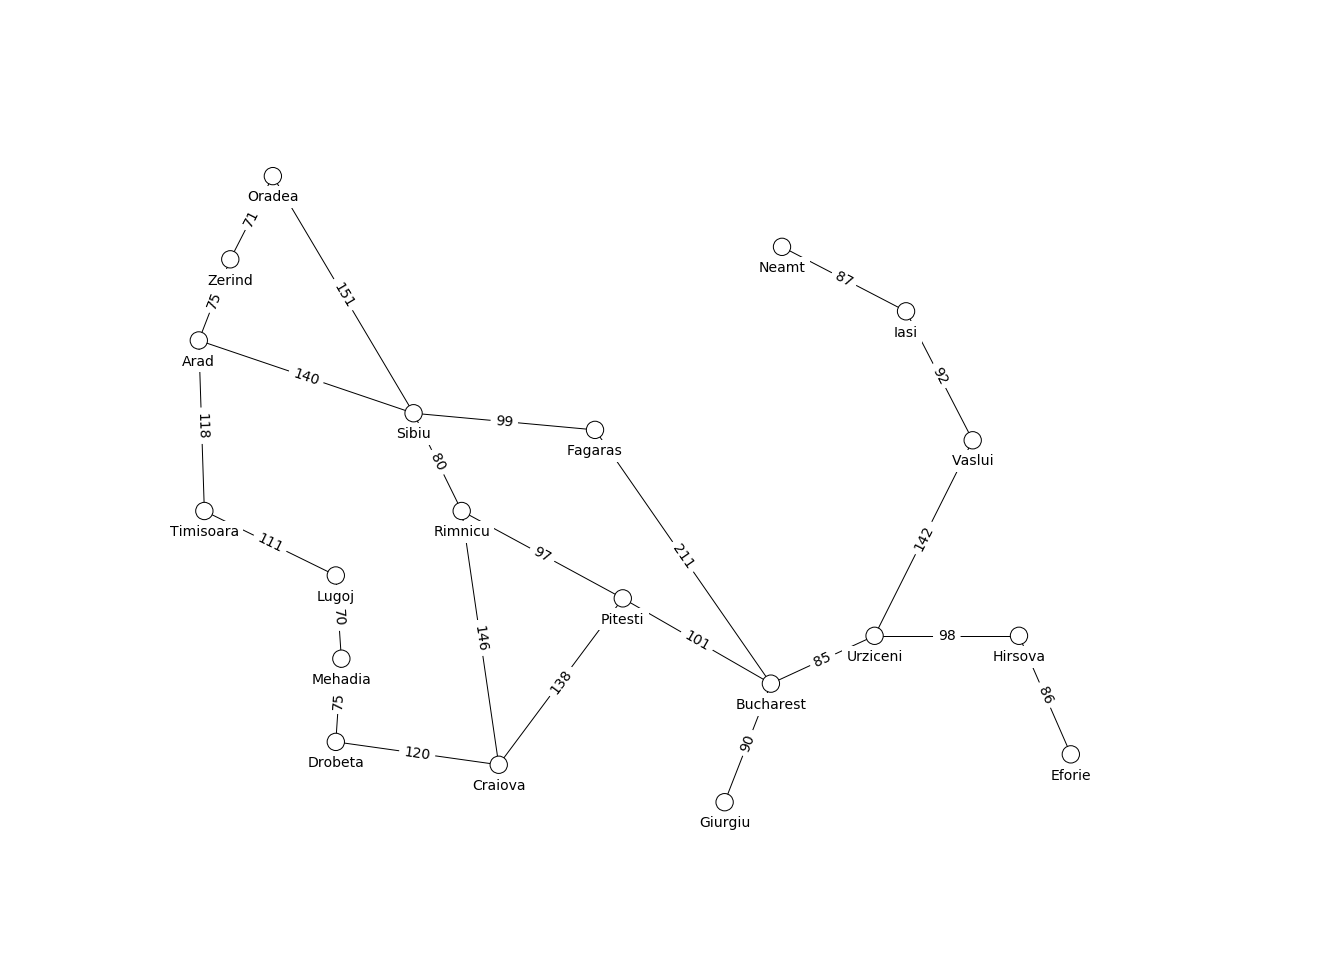

In [12]:
show_map(node_colors)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## Searching algorithms

In this section, we have visualisations of the following searching algorithms:

1. breadth_first_tree_search
2. depth_first_tree_search
3. depth_first_graph_search
4. breadth_first_search
5. best_first_graph_search
6. uniform_cost_search
7. depth_limited_search
8. iterative_deepening_search
9. astar_search
10. recursive_best_first_search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='blue'>blue</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>
* Goal node - <font color='green'>green</font>

## Breadth first tree search

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.

Let's define a problem statement:

In [13]:
romania_problem = GraphProblem('Arad', 'Fagaras', romania_map)

In [14]:
def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    global iterations
    iterations = 0
    global all_node_colors
    all_node_colors = []
    
    frontier.append(Node(problem.initial))
    
    # modify the color of frontier nodes to blue
    frontier_list = frontier.__dict__["A"][frontier.__dict__["start"]:]    
    for n in frontier_list:
        node_colors[n.state] = "blue"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    while frontier:
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return node
        
        frontier.extend(node.expand(problem))
        
        # modify the color of frontier nodes to blue
        frontier_list = frontier.__dict__["A"][frontier.__dict__["start"]:]        
        for n in frontier_list:
            node_colors[n.state] = "blue"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    return tree_search(problem, FIFOQueue())

Let's call the `modified breadth_first_tree_search` with our problem statement. Print `iterations` to see how many intermediate steps we have got 

In [15]:
breadth_first_tree_search(romania_problem).solution()

print(len(all_node_colors))
print(iterations)

86
86


Now, we use ipywidgets to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback function which are called when we interact with slider and the button.



In [16]:
def slider_callback(iteration):
    show_map(all_node_colors[iteration])

def visualize_callback(Visualize):
    if Visualize is True:
        for i in range(slider.max + 1):
            slider.value = i
#             time.sleep(.5)

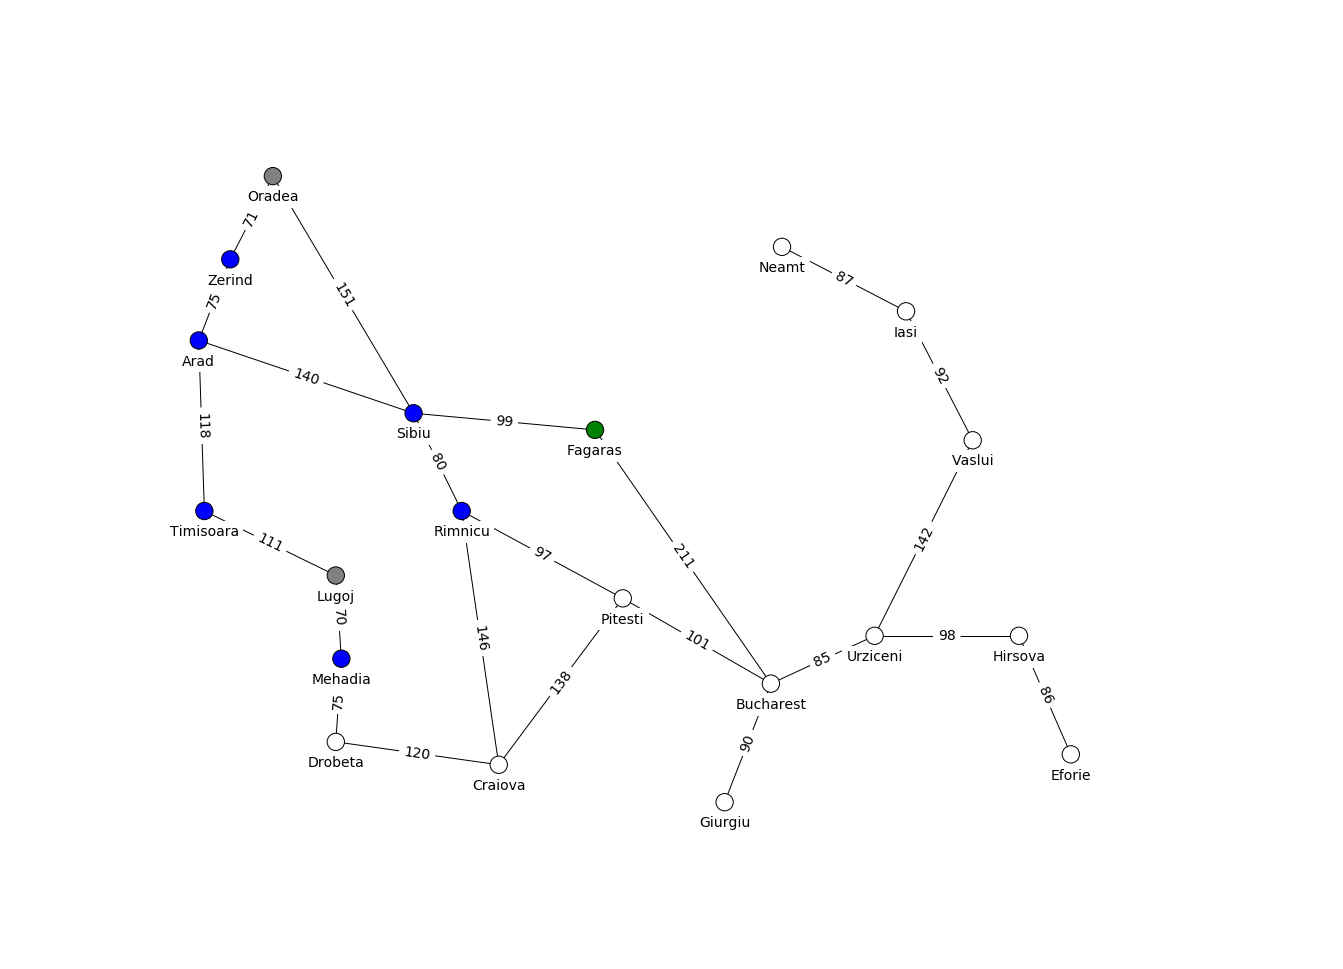

In [17]:
slider = widgets.IntSlider(min=0, max=iterations-1, step=1, value=0)
w = widgets.interactive(slider_callback, iteration = slider)
display(w)

button = widgets.ToggleButton(desctiption = "Visualize", value = False)
a = widgets.interactive(visualize_callback, Visualize = button)
display(a)

## Breadth first search

Let's change all the node_colors to starting position and define a different problem statement.

In [18]:
node_colors = dict(initial_node_colors)
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

In [19]:
def breadth_first_search(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    global iterations
    iterations = 0
    global all_node_colors
    all_node_colors = []
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return node
    
    frontier = FIFOQueue()
    frontier.append(node)
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "blue"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return child
                frontier.append(child)

                node_colors[child.state] = "blue"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [20]:
breadth_first_search(romania_problem).solution()

print(len(all_node_colors))
print(iterations)

24
24


In [21]:
def slider_callback(iteration):
    show_map(all_node_colors[iteration])

def visualize_callback(Visualize):
    if Visualize is True:
        for i in range(slider.max + 1):
            slider.value = i
#             time.sleep(.5)

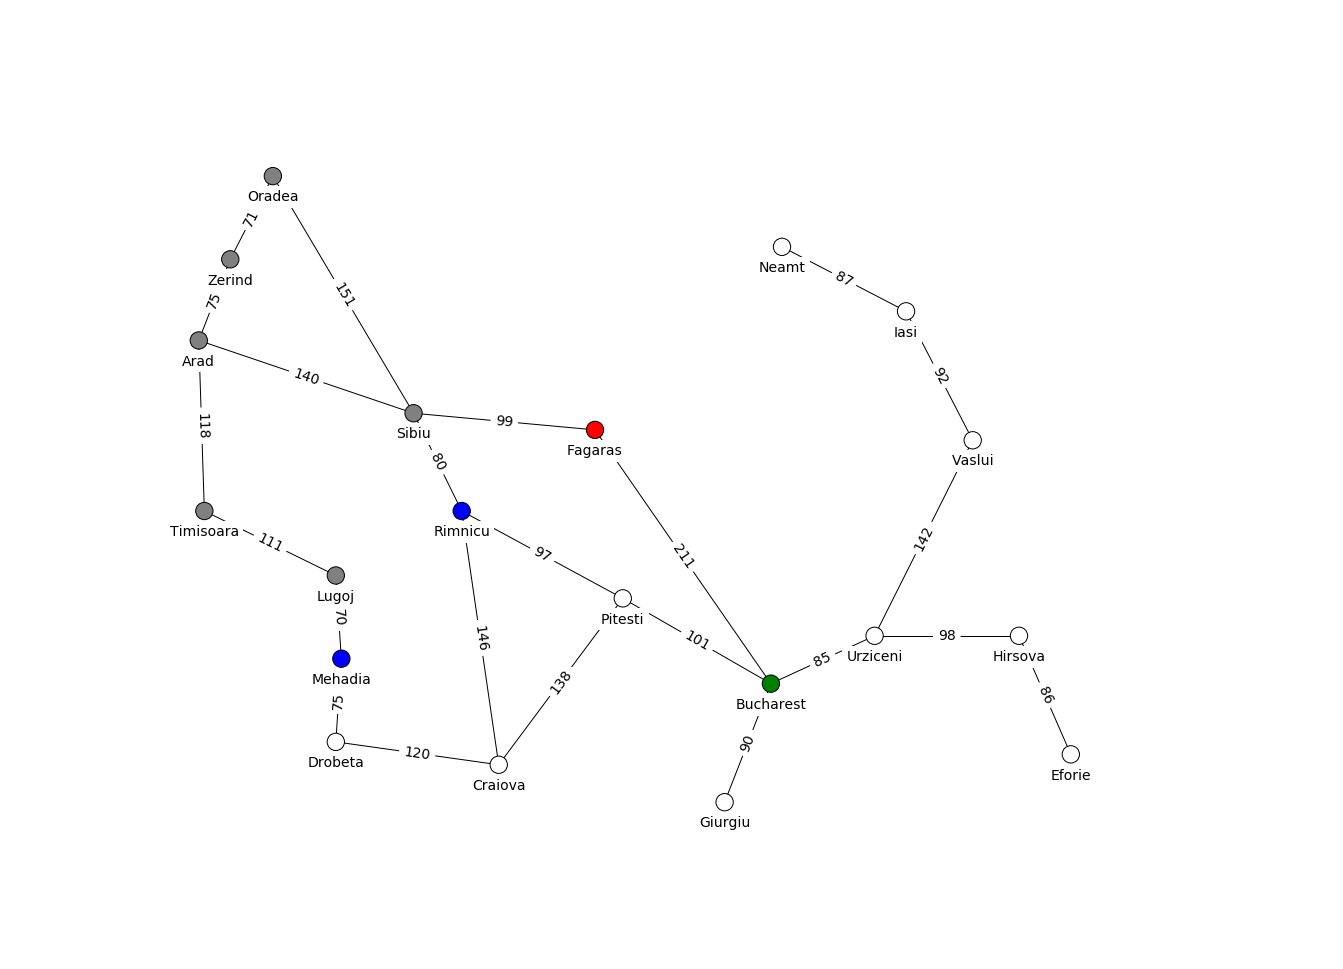

In [22]:
slider = widgets.IntSlider(min=0, max=iterations-1, step=1, value=0)
w = widgets.interactive(slider_callback, iteration = slider)
display(w)

button = widgets.ToggleButton(desctiption = "Visualize", value = False)
a = widgets.interactive(visualize_callback, Visualize = button)
display(a)

## Uniform cost search

Let's change all the node_colors to starting position and define a different problem statement.

In [23]:
node_colors = dict(initial_node_colors)
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

In [24]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    global iterations
    iterations = 0
    global all_node_colors
    all_node_colors = []
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return node
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "blue"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return node
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "blue"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "blue"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def uniform_cost_search(problem):
    "[Figure 3.14]"
    return best_first_graph_search(problem, lambda node: node.path_cost)

In [25]:
uniform_cost_search(romania_problem).solution()

print(len(all_node_colors))
print(iterations)

41
41


In [26]:
def slider_callback(iteration):
    show_map(all_node_colors[iteration])

def visualize_callback(Visualize):
    if Visualize is True:
        for i in range(slider.max + 1):
            slider.value = i
#             time.sleep(.5)

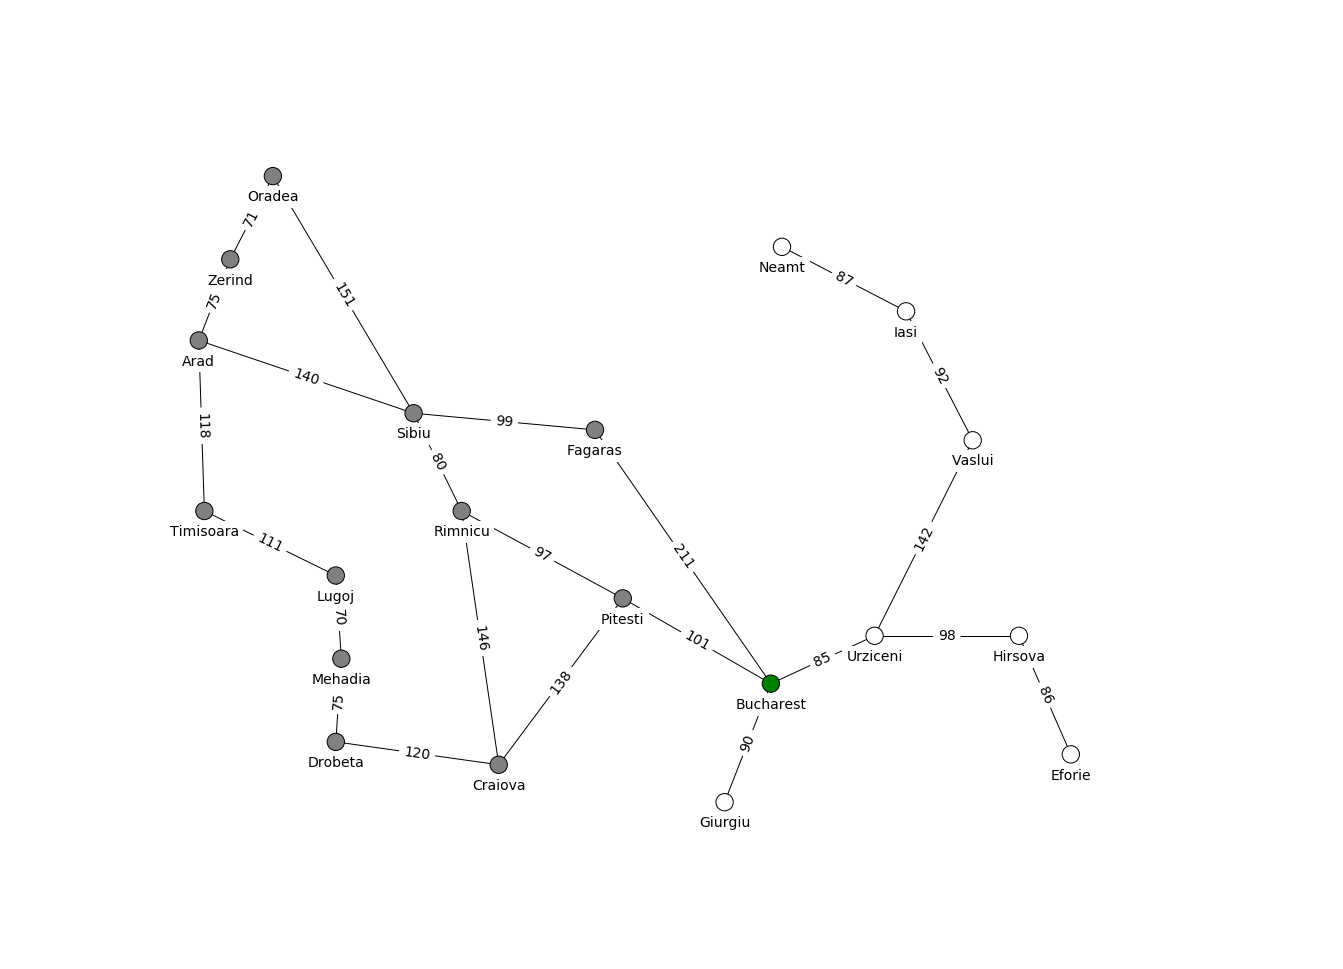

In [27]:
slider = widgets.IntSlider(min=0, max=iterations-1, step=1, value=0)
w = widgets.interactive(slider_callback, iteration = slider)
display(w)

button = widgets.ToggleButton(desctiption = "Visualize", value = False)
a = widgets.interactive(visualize_callback, Visualize = button)
display(a)

## A<sup>*</sup> search

Let's change all the node_colors to starting position and define a different problem statement.

In [28]:
node_colors = dict(initial_node_colors)
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

In [29]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    global iterations
    iterations = 0
    global all_node_colors
    all_node_colors = []
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return node
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "blue"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return node
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "blue"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "blue"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n))

In [30]:
uniform_cost_search(romania_problem).solution()

print(len(all_node_colors))
print(iterations)

41
41


In [31]:
def slider_callback(iteration):
    show_map(all_node_colors[iteration])

def visualize_callback(Visualize):
    if Visualize is True:
        for i in range(slider.max + 1):
            slider.value = i
#             time.sleep(.5)

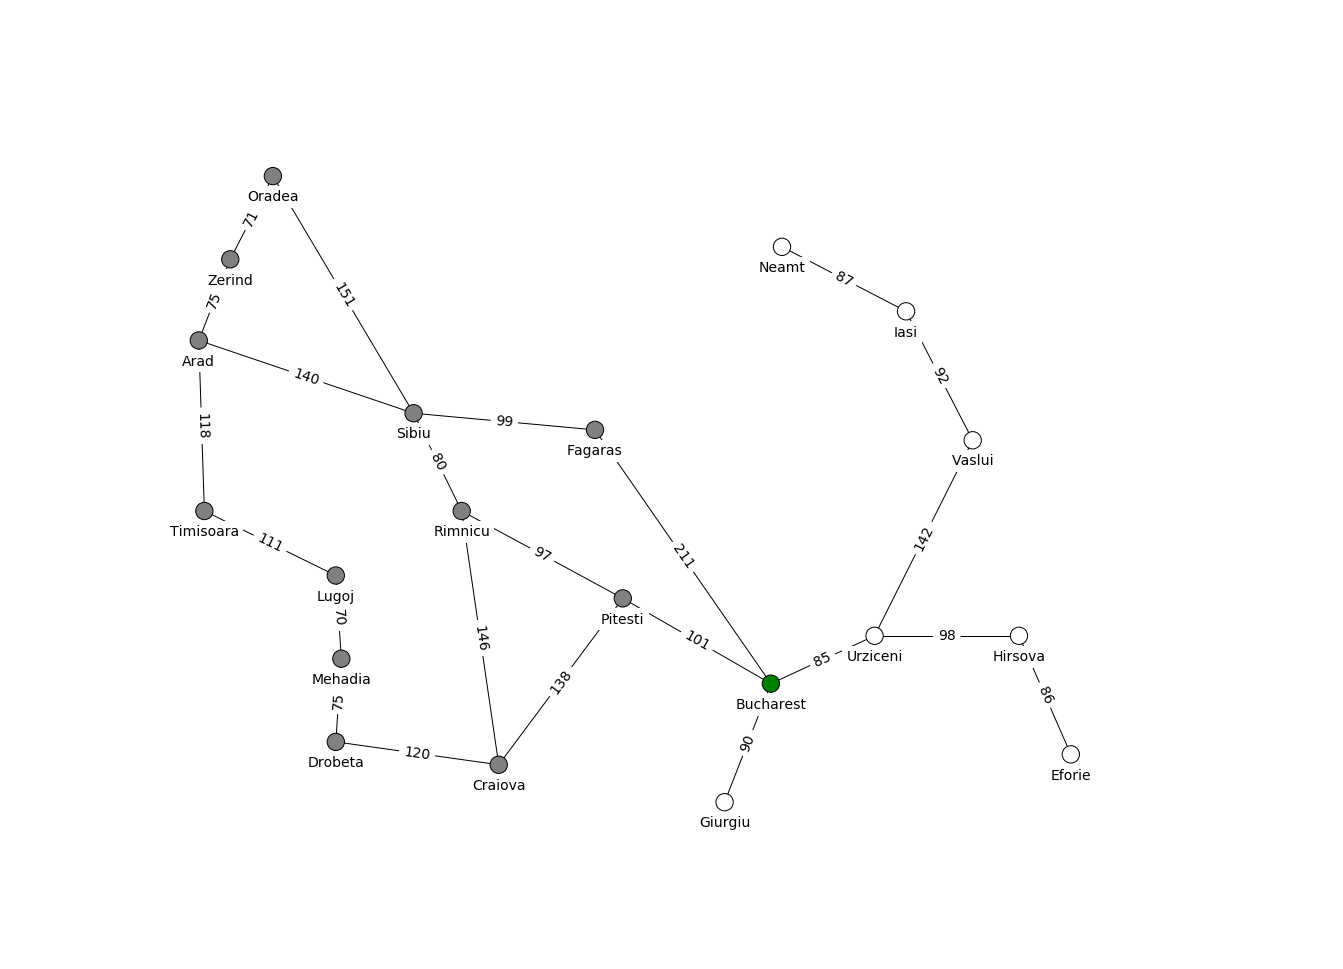

In [32]:
slider = widgets.IntSlider(min=0, max=iterations-1, step=1, value=0)
w = widgets.interactive(slider_callback, iteration = slider)
display(w)

button = widgets.ToggleButton(desctiption = "Visualize", value = False)
a = widgets.interactive(visualize_callback, Visualize = button)
display(a)